In [ ]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import numpy as np


In [5]:

#df1 = pd.read_csv("/content/drive/MyDrive/Szakdolgozat/corvinus/adathalmaz/df_test_10k.csv")
df1 = pd.read_csv('lstm_egyeni/df_test_10k.csv')

In [ ]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904593 entries, 0 to 11904592
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   uid                       int64  
 1   d                         int64  
 2   t                         int64  
 3   x                         int64  
 4   y                         int64  
 5   date                      object 
 6   days_of_week              object 
 7   cell_id                   object 
 8   lat                       float64
 9   lon                       float64
 10  temperature               float64
 11  rain                      float64
 12  weather_code              object 
 13  radius_of_gyration        float64
 14  daily_radius_of_gyration  float64
 15  is_home                   int64  
 16  is_workplace              int64  
 17  fraction_missing          float64
 18  unique_cells_count        int64  
dtypes: float64(7), int64(8), object(4)
memory usage: 1.7+ GB
None

In [ ]:
df1_og = df1[['uid', 'd', 't', 'x', 'y']]

In [ ]:
df1_og.describe()

,uid,d,t,x,y
count,1.190459e+07,1.190459e+07,1.190459e+07,1.190459e+07,1.190459e+07
mean,4.963633e+03,3.746734e+01,2.579557e+01,1.227229e+02,8.502449e+01
std,2.895632e+03,2.166258e+01,1.136477e+01,4.277367e+01,4.335986e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,2.442000e+03,1.900000e+01,1.700000e+01,9.400000e+01,5.600000e+01
50%,4.946000e+03,3.800000e+01,2.600000e+01,1.260000e+02,8.300000e+01
75%,7.478000e+03,5.600000e+01,3.500000e+01,1.560000e+02,1.110000e+02
max,9.999000e+03,7.400000e+01,4.700000e+01,2.000000e+02,2.000000e+02


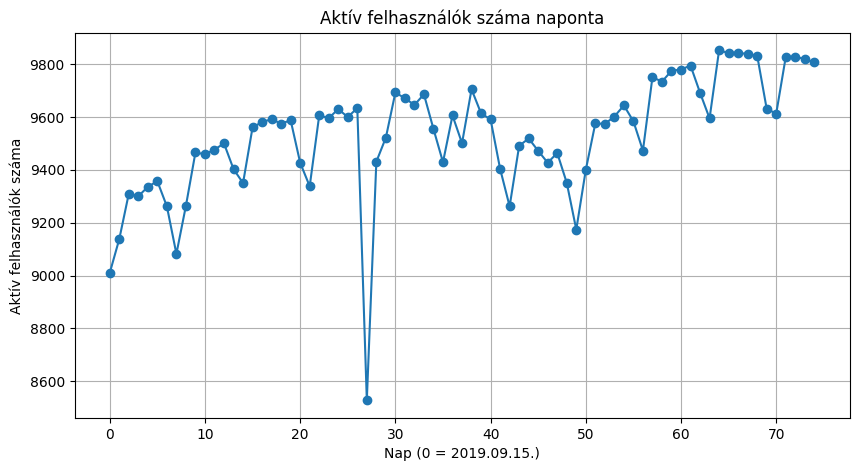

In [ ]:


# Aktív felhasználók száma naponként
active_users_by_day = df1_og.groupby('d')['uid'].nunique()

plt.figure(figsize=(10,5))
plt.plot(active_users_by_day, marker='o')
plt.title("Aktív felhasználók száma naponta")
plt.xlabel("Nap (0 = 2019.09.15.)")
plt.ylabel("Aktív felhasználók száma")
plt.grid(True)
plt.show()


In [ ]:
min_day = active_users_by_day.idxmin()
min_value = active_users_by_day.min()
print(f"A legkevesebb aktív felhasználó a(z) {min_day}. napon volt ({min_value} fő).")


A legkevesebb aktív felhasználó a(z) 27. napon volt (8528 fő).


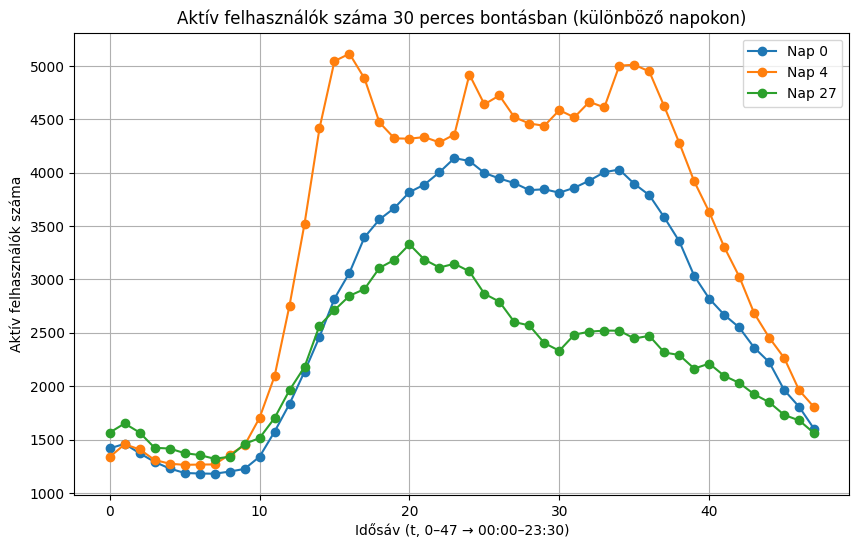

In [ ]:
# Néhány nap kiválasztása
days_to_plot = [0, 4, 27]  # ezek tetszőlegesen módosíthatók

plt.figure(figsize=(10,6))

for day in days_to_plot:
    subset = df1[df1_og['d'] == day]
    active_by_time = subset.groupby('t')['uid'].nunique()
    plt.plot(active_by_time.index, active_by_time.values, marker='o', label=f"Nap {day}")

plt.title("Aktív felhasználók száma 30 perces bontásban (különböző napokon)")
plt.xlabel("Idősáv (t, 0–47 → 00:00–23:30)")
plt.ylabel("Aktív felhasználók száma")
plt.legend()
plt.grid(True)
plt.show()

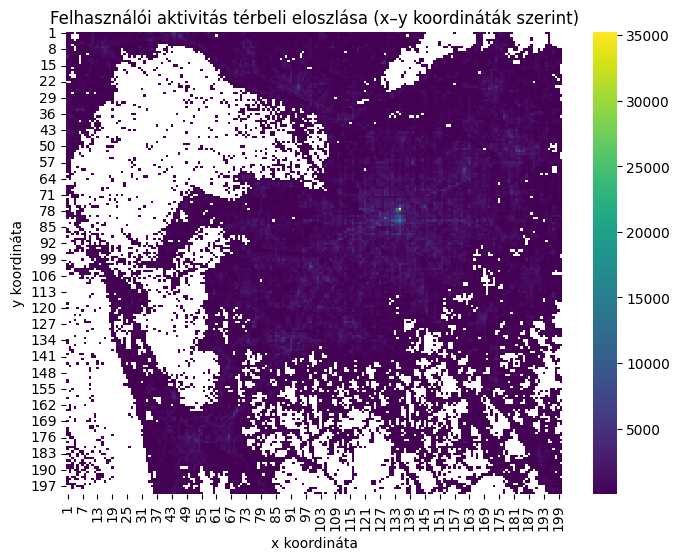

In [ ]:
# rekordok száma cellánként
cell_activity = df1.groupby(['x', 'y']).size().reset_index(name='count')

# legaktívabb cellák
cell_activity.sort_values('count', ascending=False).head(10)

pivot = cell_activity.pivot(index='y', columns='x', values='count')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, cmap='viridis')
plt.title("Felhasználói aktivitás térbeli eloszlása (x–y koordináták szerint)")
plt.xlabel("x koordináta")
plt.ylabel("y koordináta")
plt.show()

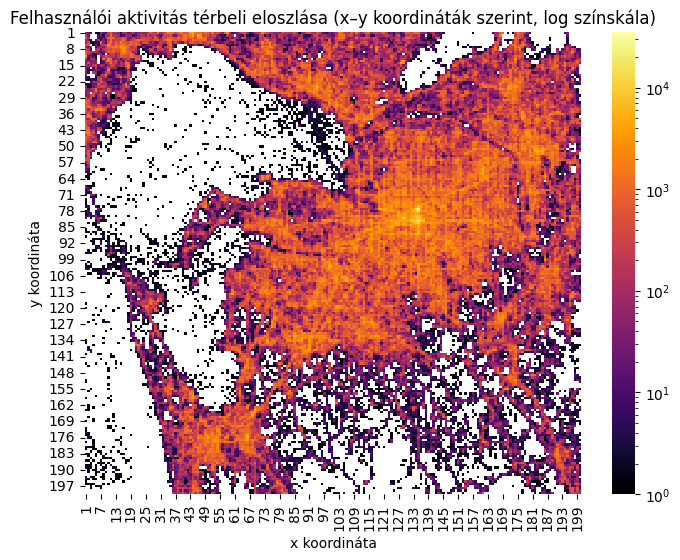

In [ ]:

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    cmap='inferno',
    norm=LogNorm()
)
plt.title("Felhasználói aktivitás térbeli eloszlása (x–y koordináták szerint, log színskála)")
plt.xlabel("x koordináta")
plt.ylabel("y koordináta")
plt.show()


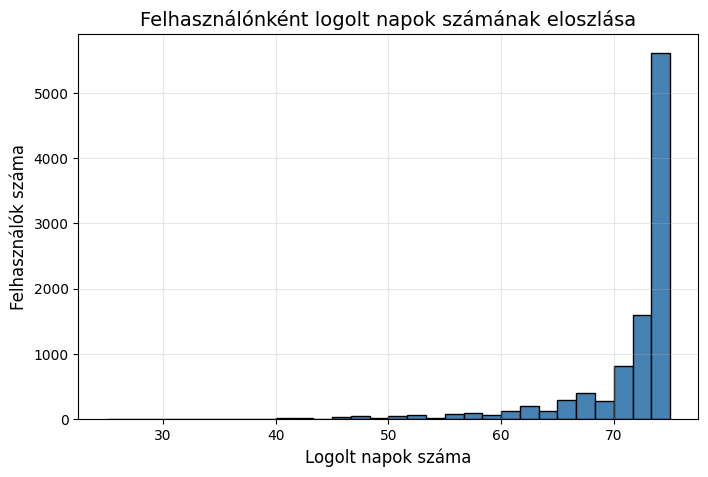

In [ ]:
# logolt napok száma 10k felhasználóra
days_per_user = df1.groupby('uid')['d'].nunique()

plt.figure(figsize=(8,5))
plt.hist(days_per_user, bins=30, color='steelblue', edgecolor='black')
plt.title("Felhasználónként logolt napok számának eloszlása", fontsize=14)
plt.xlabel("Logolt napok száma", fontsize=12)
plt.ylabel("Felhasználók száma", fontsize=12)
plt.grid(alpha=0.3)
plt.show()



In [2]:
def preprocess_dataframe(df, coarsen_factor=2):
    df = df.copy()

    if not np.issubdtype(df["date"].dtype, np.datetime64):
      df["date"] = pd.to_datetime(df["date"], errors="coerce")

    df["hour"] = df["t"].astype(int)


    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 48)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 48)
    df["is_weekend"] = (df["date"].dt.dayofweek >= 5).astype(int)

    num_cols = ["temperature", "rain", "daily_radius_of_gyration",
                "radius_of_gyration", "unique_cells_count"]

    for c in num_cols:
        if c not in df.columns:
            df[c] = 0.0

    df[num_cols] = df[num_cols].astype(float)

    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Klaszterek létrehozása
def load_and_cluster(df1, n_clusters=4):
    df_processed = preprocess_dataframe(df1)

    user_features = df_processed.groupby("uid").agg(
        mean_rg=("radius_of_gyration", "mean"),
        std_rg=("radius_of_gyration", "std"),
        mean_daily_rg=("daily_radius_of_gyration", "mean"),
        uniq_cells=("unique_cells_count", "mean"),
        frac_home=("is_home", "mean"),
        frac_work=("is_workplace", "mean"),
        weekend_ratio=("is_weekend", "mean"),
        # mean_hour_sin=("hour_sin", "mean"),
        # mean_hour_cos=("hour_cos", "mean"),
        # mean_temp=("temperature", "mean"),
        # std_temp=("temperature", "std"),
        # mean_rain=("rain", "mean")
    ).fillna(0)

    #skálázás
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(user_features)

    # kmeans klaszterezés
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    user_features["cluster"] = kmeans.fit_predict(X_scaled)

    df_proc_wclu = df_processed.merge(user_features[["cluster"]], on="uid", how="left")
    return df_proc_wclu, user_features, scaler, kmeans, X_scaled

In [6]:
df_proc_wclu, user_features, scaler, kmeans, X_scaled = load_and_cluster(df1, n_clusters=4)


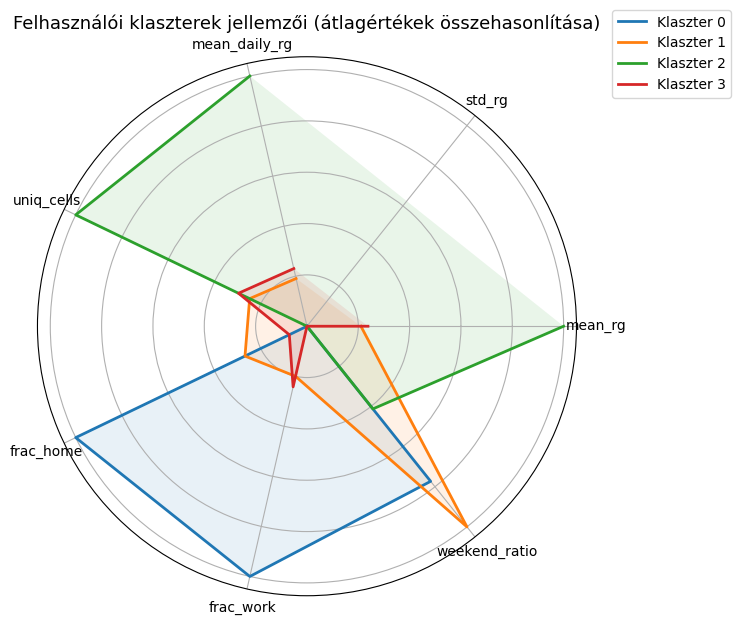

In [ ]:

# Klaszterek átlagos jellemzői
cluster_means = user_features.groupby("cluster").mean()

# A megjeleníteni kívánt jellemzők (érdemes 5–7-et választani)
features = ["mean_rg", "std_rg", "mean_daily_rg", "uniq_cells", "frac_home", "frac_work", "weekend_ratio"]
cluster_means = cluster_means[features]

# Normalizálás 0–1 tartományra (különben aránytalan lesz a skála)
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Radar chart előkészítés
labels = features
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # kör bezárása

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# Minden klaszter kirajzolása
for i, (idx, row) in enumerate(cluster_means_norm.iterrows()):
    values = row.tolist()
    values += values[:1]  # bezárja a kört
    ax.plot(angles, values, label=f'Klaszter {idx}', linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Tengelyek, címek
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
ax.set_title("Felhasználói klaszterek jellemzői (átlagértékek összehasonlítása)", size=13, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


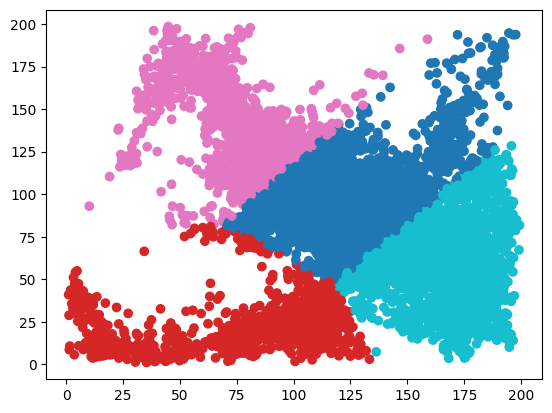

In [ ]:
# klszterek csak az x,y koordináták átlaga, azaz a térbeli távolságok alapján

from sklearn.cluster import KMeans
coords = df1.groupby('uid')[['x','y']].mean()
labels = KMeans(n_clusters=4, random_state=0).fit_predict(coords)
plt.scatter(coords['x'], coords['y'], c=labels, cmap='tab10')


In [ ]:
df1

,uid,d,t,x,y,date,days_of_week,cell_id,lat,lon,temperature,rain,weather_code,radius_of_gyration,daily_radius_of_gyration,is_home,is_workplace,fraction_missing,unique_cells_count
0,0,0,1,79,86,2019-09-15,Sunday,79_86,34.890534,136.927957,22.2,0.0,Clear,10.197634,2.653795,0,0,0.649722,409
1,0,0,2,79,86,2019-09-15,Sunday,79_86,34.890534,136.927957,22.1,0.0,Clear,10.197634,2.653795,0,0,0.649722,409
2,0,0,8,77,86,2019-09-15,Sunday,77_86,34.880518,136.927986,21.2,0.0,Clear,10.197634,2.653795,1,0,0.649722,409
3,0,0,9,77,86,2019-09-15,Sunday,77_86,34.880518,136.927986,21.0,0.0,Clear,10.197634,2.653795,1,0,0.649722,409
4,0,0,19,81,89,2019-09-15,Sunday,81_89,34.900579,136.942849,25.3,0.0,Clear,10.197634,2.653795,0,0,0.649722,409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11904588,9999,74,26,180,72,2019-11-28,Thursday,180_72,35.396185,136.856421,11.2,0.0,Cloudy,6.106990,8.973481,0,0,0.824722,128
11904589,9999,74,27,185,93,2019-11-28,Thursday,185_93,35.421448,136.961440,11.4,0.0,Cloudy,6.106990,8.973481,0,0,0.824722,128
11904590,9999,74,28,191,107,2019-11-28,Thursday,191_107,35.451594,137.031467,11.4,0.0,Cloudy,6.106990,8.973481,0,0,0.824722,128
11904591,9999,74,29,193,113,2019-11-28,Thursday,193_113,35.461639,137.061498,11.4,0.0,Cloudy,6.106990,8.973481,0,0,0.824722,128


In [18]:
def plot_users_per_cluster(df):


    # Egyedi felhasználók számolása klaszterenként
    cluster_counts = df.groupby("cluster")["uid"].nunique().sort_index()

    # Eredmények kiírása a konzolra
    print("Felhasználók száma klaszterenként:")
    print(cluster_counts)

    # Ábrázolás
    plt.figure(figsize=(8, 5))
    bars = plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color="skyblue", alpha=0.8)
    plt.title("Felhasználók száma klaszterenként")
    plt.xlabel("Klaszter ID")
    plt.ylabel("Felhasználók száma")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Értékek kiírása a bárok tetejére
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height - 200,  # kicsit a bar fölé írja
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

    plt.tight_layout()
    plt.show()

    return cluster_counts

Felhasználók száma klaszterenként:
cluster
0    1886
1    3506
2    2127
3    2481
Name: uid, dtype: int64


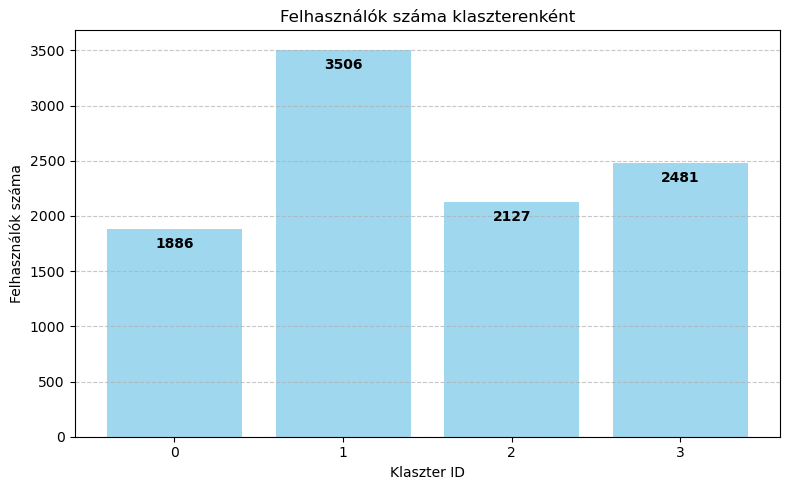

cluster
0    1886
1    3506
2    2127
3    2481
Name: uid, dtype: int64

In [19]:
plot_users_per_cluster(df_proc_wclu)

In [2]:
import pandas as pd
import numpy as np

# 1) Teljes nyers adathalmaz beolvasása
# (ha más a fájlnév vagy path, írd át)
df = pd.read_csv("yjmob100k-dataset1.csv")

# Feltételezett oszlopnevek: uid, d (nap), t (idősáv), x, y
# Ha nálad máshogy hívják, itt írd át.

# 2) Aktív napok és összes aktivitás (rekordszám) felhasználónként
user_base = (
    df
    .groupby("uid")
    .agg(
        active_days=("d", "nunique"),   # hány különböző nap szerepel a usernél
        total_activity=("d", "size")    # hány sor/rekord tartozik a userhez
    )
    .reset_index()
)

# 3) Mobilitási sugár csatolása
# Feltételezzük, hogy van egy user-level fájlod pl.:
# uid, radius_of_gyration (vagy valami hasonló néven)
rg = pd.read_csv("total_rg.csv")


# Összefűzés felhasználói szinten
user_stats = user_base.merge(rg[["uid", "radius_of_gyration"]], on="uid", how="inner")

# 4) Flag: szűkített minta (első 10 000 uid) vs teljes minta
user_stats["sample_type"] = np.where(
    user_stats["uid"] < 10000,
    "szűkített minta (10k)",
    "teljes minta (100k)"
)

print(user_stats.head())


   uid  active_days  total_activity  radius_of_gyration            sample_type
0    0           64            1261           10.197634  szűkített minta (10k)
1    1           75            2592            8.954420  szűkített minta (10k)
2    2           72            1044            4.763962  szűkített minta (10k)
3    3           71            1277            8.532737  szűkített minta (10k)
4    4           75            2091            5.981758  szűkített minta (10k)


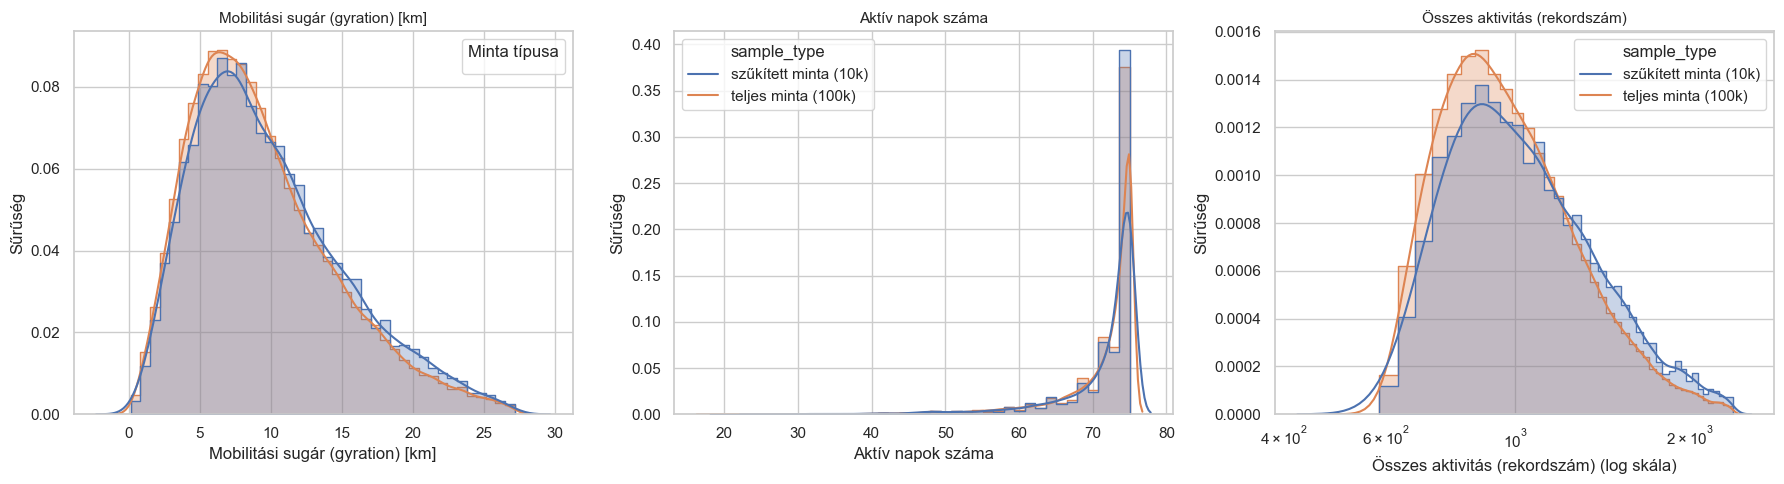

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mobilitási sugár (gyration) eloszlása

sns.set(style="whitegrid")

# Hosszú formátumra alakítás, hogy seaborn-nal könnyű legyen
plot_df = user_stats.melt(
    id_vars=["uid", "sample_type"],
    value_vars=["radius_of_gyration", "active_days", "total_activity"],
    var_name="metric",
    value_name="value"
)

metric_labels = {
    "radius_of_gyration": "Mobilitási sugár (gyration) [km]",
    "active_days": "Aktív napok száma",
    "total_activity": "Összes aktivitás (rekordszám)"
}

# 3 paneles ábra
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric in zip(axes, ["radius_of_gyration", "active_days", "total_activity"]):
    tmp = plot_df[plot_df["metric"] == metric]

    # Opció: extrém outliereket levágni, hogy jobban látszódjon az eloszlás
    # pl. 99. percentilisnél vágás:
    upper = tmp["value"].quantile(0.99)
    tmp = tmp[tmp["value"] <= upper]

    # KDE + hisztogram overlay – két minta
    sns.histplot(
        data=tmp,
        x="value",
        hue="sample_type",
        stat="density",
        element="step",
        common_norm=False,
        bins=40,
        alpha=0.3,
        ax=ax
    )
    sns.kdeplot(
        data=tmp,
        x="value",
        hue="sample_type",
        common_norm=False,
        ax=ax
    )

    ax.set_title(metric_labels[metric], fontsize=11)
    ax.set_xlabel(metric_labels[metric])
    ax.set_ylabel("Sűrűség")

    # Összes aktivitásnál gyakran érdemes log-skálát használni
    if metric == "total_activity":
        ax.set_xscale("log")
        ax.set_xlabel(metric_labels[metric] + " (log skála)")

# Egységes legenda
handles, labels = axes[0].get_legend_handles_labels()
# seaborn duplán teszi be a legendát (hist + kde), ezért csak az első kettőt hagyjuk meg:
axes[0].legend(handles[:2], labels[:2], title="Minta típusa")

plt.tight_layout()
plt.show()


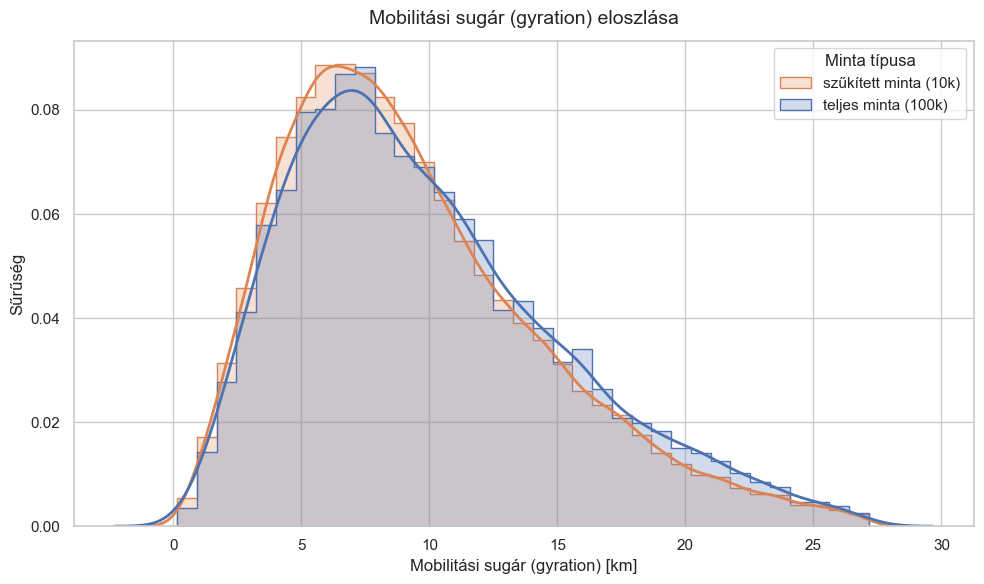

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

tmp = plot_df[plot_df["metric"] == "radius_of_gyration"].copy()
upper = tmp["value"].quantile(0.99)
tmp = tmp[tmp["value"] <= upper]

plt.figure(figsize=(10, 6))

sns.histplot(
    data=tmp,
    x="value",
    hue="sample_type",
    stat="density",  # sűrűség skála
    bins=35,
    element="step",
    alpha=0.25,
    common_norm=False    # ne normálja össze a két mintát
)

# KDE-görbe (sűrűségbecslés)
sns.kdeplot(
    data=tmp,
    x="value",
    hue="sample_type",
    common_norm=False,
    lw=2
)

plt.title("Mobilitási sugár (gyration) eloszlása", fontsize=14, pad=12)
plt.xlabel("Mobilitási sugár (gyration) [km]", fontsize=12)
plt.ylabel("Sűrűség", fontsize=12)

# jelmagyarázat
plt.legend(title="Minta típusa", labels=["szűkített minta (10k)", "teljes minta (100k)"])
plt.tight_layout()
plt.show()


In [ ]:
# Aktív napok számának eloszlása
tmp = plot_df[plot_df["metric"] == "active_days"].copy()

# 99. percentilis vágás a szélsőértékek finom kezelése miatt
upper = tmp["value"].quantile(0.99)
tmp = tmp[tmp["value"] <= upper]

plt.figure(figsize=(10, 6))

# Hisztogram
sns.histplot(
    data=tmp,
    x="value",
    hue="sample_type",
    stat="density",
    bins=35,
    element="step",
    alpha=0.25,
    common_norm=False
)

# KDE-görbe
sns.kdeplot(
    data=tmp,
    x="value",
    hue="sample_type",
    common_norm=False,
    lw=2
)

# Feliratok
plt.title("Aktív napok számának eloszlása", fontsize=14, pad=12)
plt.xlabel("Aktív napok száma", fontsize=12)
plt.ylabel("Sűrűség", fontsize=12)

# Jelmagyarázat
plt.legend(
    title="Minta típusa",
    labels=["szűkített minta (10k)", "teljes minta (100k)"]
)

plt.tight_layout()
plt.show()
